<a href="https://colab.research.google.com/github/james-hughes1/wdss-nlp-project/blob/main/WDSS_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import regex as re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data processing

In [2]:
# Load .txt file data and create DataFrame

with open("Train_text.txt") as f:
    train_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Train_labels.txt") as f:
    train_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
with open("Test_text.txt") as f:
    test_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Test_labels.txt") as f:
    test_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
text_df = pd.concat([train_text, test_text]).reset_index()
labels_df = pd.concat([train_lab, test_lab]).reset_index()
sentiment_df = pd.concat([text_df, labels_df], axis=1).reset_index()[["Content","Sentiment"]]
sentiment_df.head(10)

,Content,Sentiment
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2
5,@user LIT MY MUM 'Kerry the louboutins I wonde...,2
6,"""\"""""""" SOUL TRAIN\"""""""" OCT 27 HALLOWEEN SPECIA...",2
7,So disappointed in wwe summerslam! I want to s...,0
8,"""This is the last Sunday w/o football .....,NF...",2
9,@user @user CENA & AJ sitting in a tree K-I-S-...,1


In [3]:
# Clean data

labels = list(sentiment_df["Sentiment"])

stopword = nltk.corpus.stopwords.words('english')
stopword = [re.sub("[^a-z]", "", word) for word in stopword] # Filter punctuation

tweets_clean = []
for i in range(len(sentiment_df)):
    tweet_raw = sentiment_df["Content"].iloc[i]
    tweet_edit_1 = re.sub("@user", "", tweet_raw.lower())
    tweet_edit_2 = re.sub(r"\\u....", "", tweet_edit_1) # Remove unicode strings
    tweet_edit_3 = ""
    for word in tweet_edit_2.split(" "):
        if word not in stopword:
            tweet_edit_3 = tweet_edit_3 + " " + word # Remove stopwords
    tweet_edit_4 = re.sub(r"[^a-zA-Z0-9\s\.]", "", tweet_edit_3) # Filter punctuation
    tweet_edit_5 = re.sub(" \.|\. ", "", tweet_edit_4) # Get rid of fullstops that are outside of words (e.g. 'u.s' remains)
    tweets_clean.append(tweet_edit_5.strip())

In [4]:
# Class Summary

print("Number of tweets is: {}.".format(len(tweets_clean)))
print("Number of positive tweets is: {} (or {:.1f}%).".format(sum(np.array(labels)==2),100*sum(np.array(labels)==2)/len(labels)))
print("Number of neutral tweets is: {} (or {:.1f}%).".format(sum(np.array(labels)==1),100*sum(np.array(labels)==1)/len(labels)))
print("Number of negative tweets is: {} (or {:.1f}%).".format(sum(np.array(labels)==0),100*sum(np.array(labels)==0)/len(labels)))

Number of tweets is: 57899.
Number of positive tweets is: 20224 (or 34.9%).
Number of neutral tweets is: 26610 (or 46.0%).
Number of negative tweets is: 11065 (or 19.1%).


In [5]:
# Shuffle the data.

tweets_clean, labels = zip(*random.sample(list(zip(tweets_clean,labels)), len(tweets_clean)))
tweets_clean = list(tweets_clean)
labels = list(labels)

# Train-test split.

trainsize = int(len(tweets_clean)*0.8)

train_tweets, train_labels = tweets_clean[:trainsize], labels[:trainsize]
test_tweets, test_labels = tweets_clean[trainsize:], labels[trainsize:]

In [6]:
# Check distribution of training classes

print("TRAINING SET")
print("Number of tweets is: {}.".format(len(train_labels)))
print("Number of positive tweets is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==2),100*sum(np.array(train_labels)==2)/len(train_labels)))
print("Number of neutral tweets is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==1),100*sum(np.array(train_labels)==1)/len(train_labels)))
print("Number of negative tweets is: {} (or {:.1f}%).".format(sum(np.array(train_labels)==0),100*sum(np.array(train_labels)==0)/len(train_labels)))

TRAINING SET
Number of tweets is: 46319.
Number of positive tweets is: 16146 (or 34.9%).
Number of neutral tweets is: 21296 (or 46.0%).
Number of negative tweets is: 8877 (or 19.2%).


In [7]:
# Preprocessing hyperparameters.

vocab_size = 20000
max_length = 20

# Tokenize text data, converting to integers.

tokenizer = Tokenizer(oov_token="<OOV>",
                      num_words=vocab_size)
tokenizer.fit_on_texts(train_tweets)

train_sequences = tokenizer.texts_to_sequences(train_tweets)
test_sequences = tokenizer.texts_to_sequences(test_tweets)

# Pad sequences to standardise input sequence length.

train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

## Model Training

In [8]:
def learning_curve(history):
    plt.figure(figsize=(10,12))

    # Loss subplot.
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    # Accuracy subplot.
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

### Main Model

In [9]:
tf.random.set_seed(0)

In [16]:
# Compile model.
embedding_dim = 16

model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_1.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_1.summary()

# Train model.
history_1 = model_1.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=10,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          320000    
                                                                 
 global_average_pooling1d_5   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 320,051
Trainable params: 320,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1448/1448 - 8s - loss: 0.9935 - accuracy: 0.5129 - val_loss: 0.9264 - val_accuracy: 0.5674 - 8s/epoch - 6ms/step
Epoch 2/10
1448/1448 - 4s - loss: 0.8622 - accuracy: 0.5976 - val_loss: 0.8413 - val_accuracy: 0.6084 - 4s/epoch - 3ms/ste

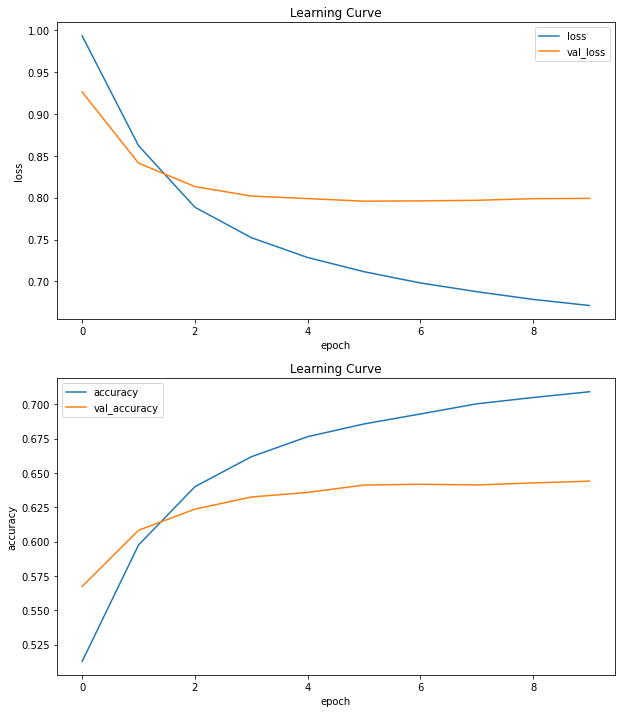

In [17]:
# Plot learning curve.
learning_curve(history_1)

### Other Models

In [ ]:
# Compile model.
embedding_dim = 32

model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_2.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_2.summary()

# Train model.
history_2 = model_2.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=20,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 32)          640000    
                                                                 
 conv1d_17 (Conv1D)          (None, None, 64)          6208      
                                                                 
 global_average_pooling1d_17  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 3)                 195       
                                                                 
Total params: 646,403
Trainable params: 646,403
Non-trainable params: 0
_______________________________________________

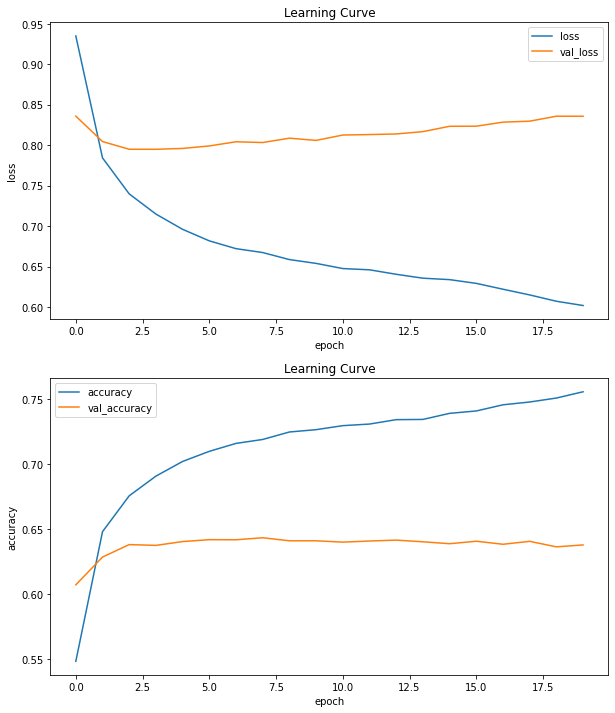

In [ ]:
# Plot learning curve.
learning_curve(history_2)

In [ ]:
# Compile model.
embedding_dim = 8

model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_3.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_3.summary()

# Train model.
history_3 = model_3.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=20,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 8)           160000    
                                                                 
 conv1d_7 (Conv1D)           (None, None, 16)          400       
                                                                 
 average_pooling1d (AverageP  (None, None, 16)         0         
 ooling1D)                                                       
                                                                 
 dropout_6 (Dropout)         (None, None, 16)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, None, 32)          1568      
                                                                 
 global_average_pooling1d_8   (None, 32)               0         
 (GlobalAveragePooling1D)                             

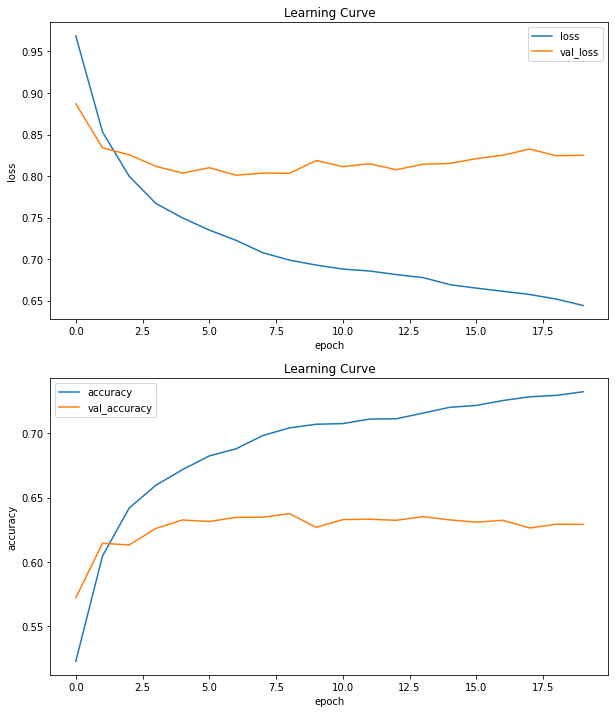

In [ ]:
# Plot learning curve.
learning_curve(history_3)

In [ ]:
# Compile model.
embedding_dim = 16

model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_4.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_4.summary()

# Train model.
history_4 = model_4.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=20,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 16)          320000    
                                                                 
 conv1d_9 (Conv1D)           (None, None, 32)          1568      
                                                                 
 global_average_pooling1d_9   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 264       
                                                                 
 dropout_9 (Dropout)         (None, 8)                 0         
                                                      

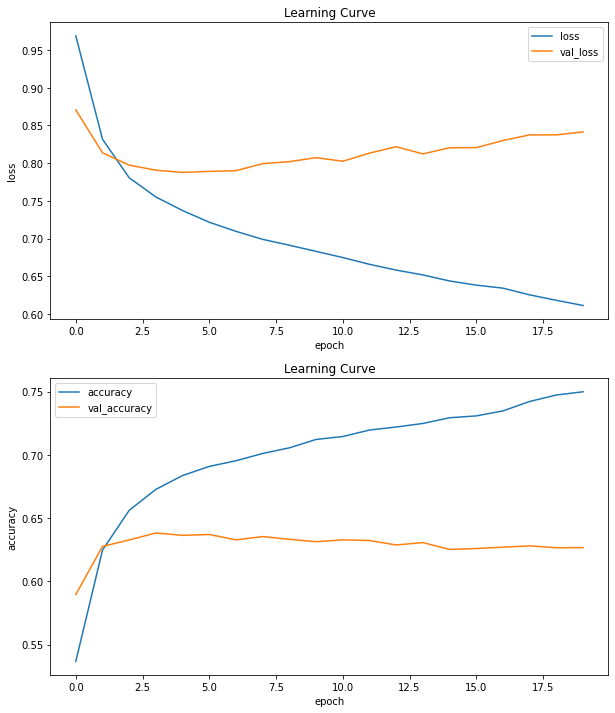

In [ ]:
# Plot learning curve.
learning_curve(history_4)

In [ ]:
# Compile model.
embedding_dim = 16

model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_5.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_5.summary()

# Train model.
history_5 = model_5.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=25,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 16)          320000    
                                                                 
 dropout_18 (Dropout)        (None, None, 16)          0         
                                                                 
 lstm_5 (LSTM)               (None, 2)                 152       
                                                                 
 dropout_19 (Dropout)        (None, 2)                 0         
                                                                 
 dense_16 (Dense)            (None, 3)                 9         
                                                                 
Total params: 320,161
Trainable params: 320,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1448/1448 - 18s - loss: 0.9988 - acc

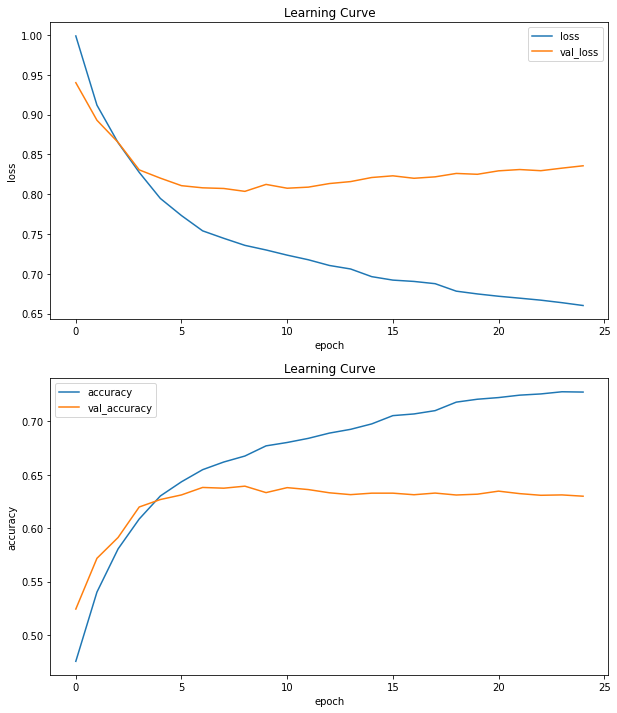

In [ ]:
# Plot learning curve.
learning_curve(history_5)

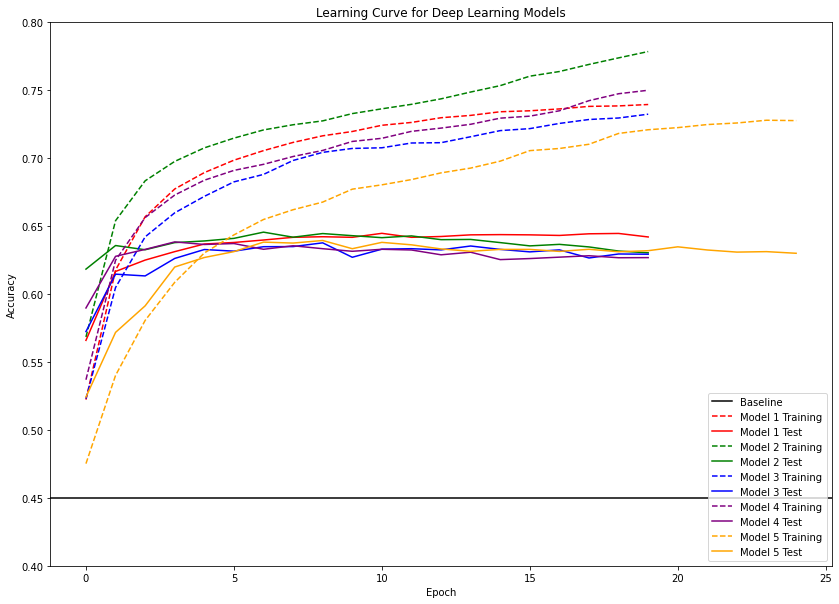

In [ ]:
# Plot all five learning curves on the same axes.
plt.figure(figsize=(14,10))

plt.axhline(0.45, label='Baseline', color='black')
plt.plot(history_1.history['accuracy'], label='Model 1 Training', color='red', linestyle='dashed')
plt.plot(history_1.history['val_accuracy'], label='Model 1 Test', color='red')
plt.plot(history_2.history['accuracy'], label='Model 2 Training', color='green', linestyle='dashed')
plt.plot(history_2.history['val_accuracy'], label='Model 2 Test', color='green')
plt.plot(history_3.history['accuracy'], label='Model 3 Training', color='blue', linestyle='dashed')
plt.plot(history_3.history['val_accuracy'], label='Model 3 Test', color='blue')
plt.plot(history_4.history['accuracy'], label='Model 4 Training', color='purple', linestyle='dashed')
plt.plot(history_4.history['val_accuracy'], label='Model 4 Test', color='purple')
plt.plot(history_5.history['accuracy'], label='Model 5 Training', color='orange', linestyle='dashed')
plt.plot(history_5.history['val_accuracy'], label='Model 5 Test', color='orange')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0.4,0.8))
plt.title('Learning Curve for Deep Learning Models')

plt.show()
     

## Validation & Confusion Matrix

In [18]:
with open("Val_text.txt") as f:
    val_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Val_labels.txt") as f:
    val_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
sentiment_val_df = pd.concat([val_text, val_lab], axis=1).reset_index()[["Content","Sentiment"]]
sentiment_val_df.head(10)

,Content,Sentiment
0,Dark Souls 3 April Launch Date Confirmed With ...,1
1,"""National hot dog day, national tequila day, t...",2
2,When girls become bandwagon fans of the Packer...,0
3,@user I may or may not have searched it up on ...,1
4,Here's your starting TUESDAY MORNING Line up a...,1
5,"@user F-Main, are you in the office tomorrow i...",1
6,#US 1st Lady Michelle Obama speaking at the 20...,2
7,Omg this show is so predictable even for the 3...,0
8,"""What a round by Paul Dunne, good luck tomorro...",2
9,Irving Plaza NYC Blackout Saturday night. Got ...,1


In [108]:
sentiment_val_df.iloc[:5]

,Content,Sentiment
0,Dark Souls 3 April Launch Date Confirmed With ...,1
1,"""National hot dog day, national tequila day, t...",2
2,When girls become bandwagon fans of the Packer...,0
3,@user I may or may not have searched it up on ...,1
4,Here's your starting TUESDAY MORNING Line up a...,1


In [102]:
sentiment_val_df[sentiment_val_df["Content"].str.contains("nick")]

,Content,Sentiment
646,@user Friday\u2019s the main day!!!! Knicks vs...,2
801,What up\u002c we bout to touch thuus Ainsworth...,1
1035,The Knicks got the Heat at MSG tomorrow! Gonna...,2
1173,The regular-season opener Thursday between the...,1
1286,the 2nd and 4th are nicki's best vma looks. \n,2
1945,I'm at work for 14.5 hours tomorrow lmao someo...,1
1954,Brooklyn Nets vs. the New York Knicks has been...,1
1959,Sunday and a lovely #RaggedTalk on Skiing in S...,2
1985,Disappointed the Knicks vs Nets game got cance...,0


In [109]:
tweets_clean_val[:5]

['qt  original draft 7th book remus lupin survived battle hogwartshappybirthdayremuslupin',
 'ben smith  smith concussion remains lineup thursday curtis nhl sj',
 'sorry bout stream last night crashed tonight sureback minecraft pc tomorrow night',
 'chase headleys rbi double 8th inning david price snapped yankees streak 33 consecutive scoreless innings blue jays',
 'alciato bee invest 150 million january another 200 summer plans bring messi 2017']

In [110]:
# Transform Data

labels_val= list(sentiment_val_df["Sentiment"])
tweets_clean_val = []

for i in range(len(sentiment_val_df)):
    tweet_raw = sentiment_val_df["Content"].iloc[i]
    tweet_edit_1 = re.sub("@user", "", tweet_raw.lower())
    tweet_edit_2 = re.sub(r"\\u....", "", tweet_edit_1) # Remove unicode strings
    tweet_edit_3 = ""
    for word in tweet_edit_2.split(" "):
        if word not in stopword:
            tweet_edit_3 = tweet_edit_3 + " " + word # Remove stopwords
    tweet_edit_4 = re.sub(r"[^a-zA-Z0-9\s\.]", "", tweet_edit_3) # Filter punctuation
    tweet_edit_5 = re.sub(" \.|\. ", "", tweet_edit_4) # Get rid of fullstops that are outside of words (e.g. 'u.s' remains)
    tweets_clean_val.append(tweet_edit_5.strip())

# Tokenize and pad

val_sequences = tokenizer.texts_to_sequences(tweets_clean_val)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

In [111]:
# Class Summary

print("VALIDATION SET")
print("Number of tweets is: {}.".format(len(labels_val)))
print("Number of positive tweets is: {} (or {:.1f}%).".format(sum(np.array(labels_val)==2),100*sum(np.array(labels_val)==2)/len(labels_val)))
print("Number of neutral tweets is: {} (or {:.1f}%).".format(sum(np.array(labels_val)==1),100*sum(np.array(labels_val)==1)/len(labels_val)))
print("Number of negative tweets is: {} (or {:.1f}%).".format(sum(np.array(labels_val)==0),100*sum(np.array(labels_val)==0)/len(labels_val)))

VALIDATION SET
Number of tweets is: 2000.
Number of positive tweets is: 819 (or 41.0%).
Number of neutral tweets is: 869 (or 43.5%).
Number of negative tweets is: 312 (or 15.6%).


In [112]:
# Use model to prediction validation data labels.

predicted_val = model_1.predict(val_padded)

63/63 [==============================] - 0s 1ms/step


In [150]:
# Tabulate model outputs, predictions, confidence and actual labels in DataFrame.

prediction_df = pd.DataFrame(predicted_val, columns = ["Predicted Negative", "Predicted Neutral", "Predicted Positive"])
prediction_df["Predicted"] = np.argmax(predicted_val, axis=1)
prediction_df["Confidence"] = np.max(predicted_val, axis=1)
prediction_df["Actual"] = labels_val
prediction_df

,Predicted Negative,Predicted Neutral,Predicted Positive,Predicted,Confidence,Actual
0,0.011760,0.824303,0.163937,1,0.824303,1
1,0.002260,0.036864,0.960876,2,0.960876,2
2,0.031455,0.827684,0.140861,1,0.827684,0
3,0.067390,0.676929,0.255681,1,0.676929,1
4,0.009694,0.796444,0.193861,1,0.796444,1
...,...,...,...,...,...,...
1995,0.005636,0.692151,0.302212,1,0.692151,1
1996,0.973897,0.022818,0.003284,0,0.973897,1
1997,0.019332,0.806277,0.174391,1,0.806277,2
1998,0.062198,0.746974,0.190828,1,0.746974,1


In [155]:
# Compute confusion matrix and display, along with accuracy across classes.

def conf_matrix_display(df_filtered):
    conf_matrix_filtered = np.array(tf.math.confusion_matrix(df_filtered["Actual"], df_filtered["Predicted"]))
    confusion_df_filtered = pd.DataFrame(conf_matrix_filtered, columns=["Predicted Negative", "Predicted Neutral", "Predicted Positive"])
    confusion_df_filtered.set_index([pd.Index(["Actual Negative", "Actual Neutral", "Actual Positive"]), ], inplace=True)
    confusion_df_filtered["Accuracy"] = [conf_matrix_filtered[i,i]/np.sum(conf_matrix_filtered, axis=1)[i] for i in range(3)]
    # Here we consider "positive" and "negative" together as "signal".
    confusion_df_filtered["False Signal Rate"] = [conf_matrix_filtered[0,2]/np.sum(conf_matrix_filtered, axis=1)[0],
                                        (conf_matrix_filtered[1,0]+conf_matrix_filtered[1,2])/np.sum(conf_matrix_filtered, axis=1)[1],
                                        conf_matrix_filtered[0,0]/np.sum(conf_matrix_filtered, axis=1)[2]]
    display(confusion_df_filtered)
    print("Total sample size: ", np.sum(conf_matrix_filtered.flatten()))
    print("Total accuracy: ", np.sum(conf_matrix_filtered.diagonal())/np.sum(conf_matrix_filtered.flatten()))

In [168]:
# Display unfiltered confusion matrix.
print("Unfiltered confusion matrix")
conf_matrix_display(prediction_df)

Unfiltered confusion matrix


,Predicted Negative,Predicted Neutral,Predicted Positive,Accuracy,False Signal Rate
Actual Negative,119,146,47,0.381410,0.150641
Actual Neutral,55,639,175,0.735328,0.264672
Actual Positive,29,244,546,0.666667,0.145299


Total sample size:  2000
Total accuracy:  0.652


In [169]:
# Display confusion matrix for prediction confidence over 0.7.
print("Confusion matrix; confidence > 0.7")
conf_matrix_display(prediction_df[prediction_df["Confidence"] > 0.7])

Confusion matrix; confidence > 0.7


,Predicted Negative,Predicted Neutral,Predicted Positive,Accuracy,False Signal Rate
Actual Negative,63,47,12,0.516393,0.098361
Actual Neutral,15,305,60,0.802632,0.197368
Actual Positive,6,85,379,0.806383,0.134043


Total sample size:  972
Total accuracy:  0.7685185185185185


In [170]:
# Display confusion matrix for prediction confidence over 0.8.
print("Confusion matrix; confidence > 0.8")
conf_matrix_display(prediction_df[prediction_df["Confidence"] > 0.8])

Confusion matrix; confidence > 0.8


,Predicted Negative,Predicted Neutral,Predicted Positive,Accuracy,False Signal Rate
Actual Negative,38,18,6,0.612903,0.096774
Actual Neutral,10,179,36,0.795556,0.204444
Actual Positive,3,48,294,0.852174,0.110145


Total sample size:  632
Total accuracy:  0.8085443037974683


In [171]:
# Display confusion matrix for prediction confidence over 0.9.
print("Confusion matrix; confidence > 0.9")
conf_matrix_display(prediction_df[prediction_df["Confidence"] > 0.9])

Confusion matrix; confidence > 0.9


,Predicted Negative,Predicted Neutral,Predicted Positive,Accuracy,False Signal Rate
Actual Negative,22,2,2,0.846154,0.076923
Actual Neutral,5,65,15,0.764706,0.235294
Actual Positive,3,12,192,0.927536,0.106280


Total sample size:  318
Total accuracy:  0.8773584905660378


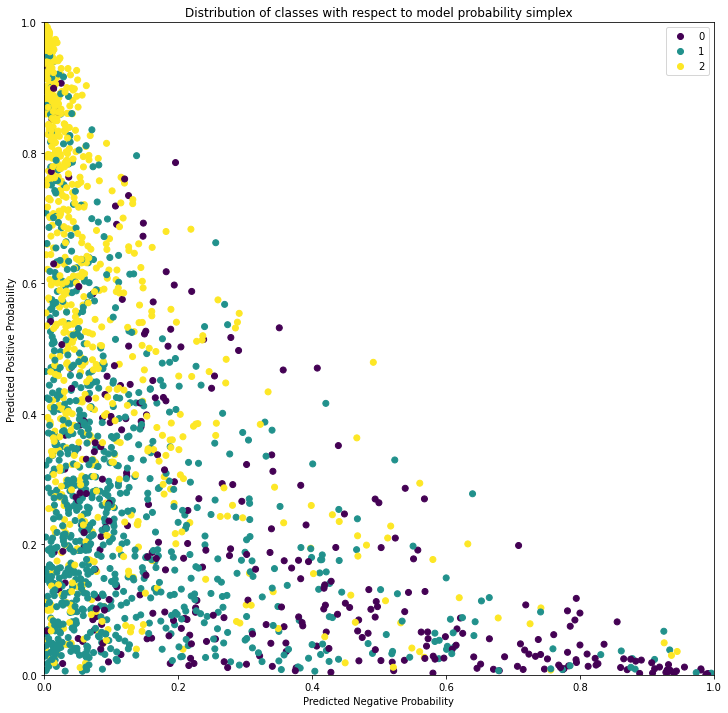

In [173]:
# Plot classes across model probability predictions.
plt.figure(figsize=(12,12))
scatter = plt.scatter(data=prediction_df, x="Predicted Negative", y="Predicted Positive",c="Actual")

#Formatting
plt.xlim((0,1))
plt.xlabel("Predicted Negative Probability")
plt.ylabel("Predicted Positive Probability")
plt.ylim((0,1))
plt.title("Distribution of classes with respect to model probability simplex")
handles, labels = scatter.legend_elements()
plt.legend(handles, [0,1,2])

plt.show()

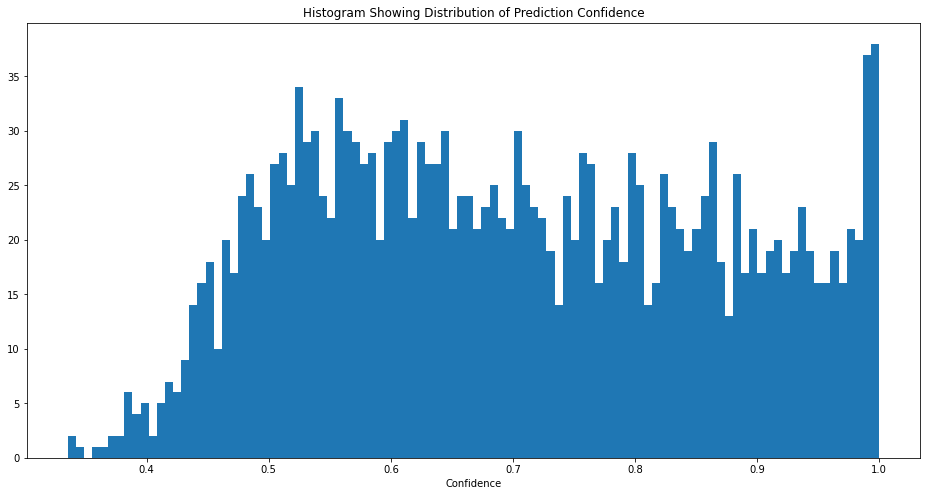

In [175]:
# Plot distribution of confidence.
plt.figure(figsize=(16,8))
plt.hist(np.max(predicted_val, axis=1), bins = 100)

# Formatting
plt.xlabel("Confidence")
plt.title("Histogram Showing Distribution of Prediction Confidence")

plt.show()

# Sentiment Analysis

In [202]:
# Read and format the twitter scrape .csv file
# Add the .csv file to the workspace or this won't work

tweets_df = pd.read_csv("Twitter Scrape 4_Reduced.csv", usecols=['ID', 'Date', 'Likes', 'Replies', 'Retweets', 'User ID', 'Username', 
                                                                 'Followers', 'Verified', 'Content', 'Time', 'Category'],
                        encoding="UTF-8")
tweets_df["Time"] = pd.to_datetime(tweets_df["Time"], format='%H:%M:%S').dt.time
tweets_df["Date"] = pd.to_datetime(tweets_df["Date"], format='%Y-%m-%d').dt.date


tweets_clean = []
for i in range(len(tweets_df)):
    tweet_raw = tweets_df["Content"][i]
    tweet_edit_1 = re.sub("@user", "", tweet_raw.lower())
    tweet_edit_2 = re.sub(r"\\u....", "", tweet_edit_1) # Remove unicode strings
    tweet_edit_3 = ""
    for word in tweet_edit_2.split(" "):
        if word not in stopword:
            tweet_edit_3 = tweet_edit_3 + " " + word # Remove stopwords
    tweet_edit_4 = re.sub(r"[^a-zA-Z0-9\s\.]", "", tweet_edit_3) # Filter punctuation
    tweet_edit_5 = re.sub(" \.|\. ", "", tweet_edit_4) # Get rid of fullstops that are outside of words (e.g. 'u.s' remains)
    tweets_clean.append(tweet_edit_5.strip())

# Preprocessing hyperparameters.

vocab_size = 20000
max_length = 20

# Tokenize text data, converting to integers.

sequences = tokenizer.texts_to_sequences(tweets_clean)

# Pad sequences to standardise input sequence length.

padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [203]:
# Use model to create predictions.

predicted_tweets = model_1.predict(padded_sequences)
tweets_df["Negative Probability"] = predicted_tweets[:,0]
tweets_df["Neutral Probability"] = predicted_tweets[:,1]
tweets_df["Positive Probability"] = predicted_tweets[:,2]

111/111 [==============================] - 0s 1ms/step


In [204]:
tweets_df

,ID,Date,Likes,Replies,Retweets,User ID,Username,Followers,Verified,Content,Time,Category,Negative Probability,Neutral Probability,Positive Probability
0,1063077542490505216,2018-11-15,42,3,32,214842351,PEspinosaC,123749,1,Met with Costa Rican Environment Minister Carl...,14:33:31,Politician,0.458803,0.409985,0.131213
1,1063102498725072896,2018-11-15,56,6,36,17463923,UNFCCC,962486,1,"The challenges of #climatechange, #desertifica...",16:12:41,International Organisation,0.248608,0.620720,0.130673
2,1063523438529314816,2018-11-16,11,0,12,202313343,WRIClimate,72262,0,BLOG: The upcoming climate change conference i...,20:05:21,International Organisation,0.120253,0.859639,0.020107
3,1063718384670568448,2018-11-17,968,24,641,17463923,UNFCCC,962486,1,Only 15 days until the @UN’s #ClimateChange co...,09:00:00,International Organisation,0.055448,0.757456,0.187096
4,1063897312856920065,2018-11-17,1182,54,600,811229675758505984,antonioguterres,2029959,1,There is no alternative to the #ParisAgreement...,20:51:00,Politician,0.204585,0.717950,0.077465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3546,1079340099631042560,2018-12-30,4,0,3,339754094,Connect4Climate,152693,1,"The needs for #ClimateAction are great, the op...",11:35:07,Activist,0.163311,0.249675,0.587014
3547,1079437285584703488,2018-12-30,13,0,9,1019974187975430144,ExtinctionR,424553,1,".@moorlandernews - ""The new agreements reached...",18:01:18,Activist,0.774957,0.211175,0.013867
3548,1079437952931966976,2018-12-30,2234,197,373,16220555,ElizabethMay,320612,1,"Jason, You should have asked me. I was at COP2...",18:03:57,Politician,0.055706,0.885098,0.059196
3549,1079473478594486272,2018-12-30,9,0,8,339754094,Connect4Climate,152693,1,[Blog] Water scarcity could cost some regions ...,20:25:07,Activist,0.612726,0.378262,0.009012


In [205]:
tweets_df.columns

Index(['ID', 'Date', 'Likes', 'Replies', 'Retweets', 'User ID', 'Username',
       'Followers', 'Verified', 'Content', 'Time', 'Category',
       'Negative Probability', 'Neutral Probability', 'Positive Probability'],
      dtype='object')

In [206]:
# Save predictions via .csv.
tweets_df.to_csv("Twitter Scrape 4_Sentiment.csv", index=False)

### Preliminary Plots

In [207]:

#%%
d = tweets_df.groupby(['Date'])['Sentiment'].mean().reset_index()

d.plot(x='Date',y='Sentiment',kind = 'line', rot = 45,figsize=(16,12))
plt.title("Mean Sentiment through COP26 Conference",fontsize = 20)
plt.ylabel("Mean Sentiment",fontsize = 15)
plt.xlabel("Date",fontsize = 15)

d = tweets_df.groupby(['Category'])['Sentiment'].mean().reset_index()

d.plot(x='Category',y='Sentiment',kind = 'scatter', rot = 45,figsize=(16,8),ylim=(-0.0,2.0))
plt.title("Mean Sentiment Across Categories",fontsize = 20)
plt.ylabel("Mean Sentiment",fontsize = 15)
plt.xlabel("Date",fontsize = 15)

KeyError: ignored